In [1]:
import json
from pprint import pprint
import pingparsing
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def iperf3_parser(file):
    """Returns arrays with bitrate, jitter, packet loss"""

    bitrate_values = []
    jitter_values = []
    packet_loss_values = []
    with open(file) as f:
        data = json.load(f)
        
        reverse = data['start']['test_start']['reverse']
        if reverse:
            print("DOWNLINK Performance Measurement")
        else:
            print("UPLINK Performance Measurement")

         #pprint(data['start'])
        local_host = data['start']['connected'][0]['local_host']
        print("Local host: ", local_host)

        remote_host = data['start']['connected'][0]['remote_host']
        print("Remote host: ", remote_host)

        timestamp = data['start']['timestamp']['time']
        print("Experiment started at: ", timestamp)

        duration = data['start']['test_start']['duration']
        print("Experiment duration (s): ", duration)

        protocol = data['start']['test_start']['protocol']
        print("Protocol: ", protocol)

        intervals = data['intervals']
        for interval in intervals:
            if protocol == 'UDP':
                jitter = interval['sum']['jitter_ms']
                jitter_values.append(jitter)
                packet_loss = interval['sum']['lost_percent']
                packet_loss_values.append(packet_loss)
            elif protocol == 'TCP':
                bitrate = interval['sum']['bits_per_second']
                bitrate_values.append(bitrate)
        if protocol == 'UDP':
            return jitter_values, packet_loss_values
        elif protocol == 'TCP':
            return bitrate_values

def ping_parser(file):
    """Return array with RTTs"""
    
    RTT_values = []
    with open(file) as f:
        parser = pingparsing.PingParsing()
        stats = parser.parse(f.read())
        json.dumps(stats.as_dict())
        for icmp_reply in stats.icmp_replies:
            RTT_values.append(icmp_reply['time'])
    
    return RTT_values

def get_stats(values):
    mean = np.round(np.mean(values), 3) # mean
    std = np.round(np.std(values), 3) # standard deviation
    sem = np.round(stats.sem(values), 3) # standard mean error
    confidence_interval = np.round(stats.norm.interval(alpha=0.95, loc=mean, scale=sem), 3) # 95% confidence interval
    print(" - Mean:", mean)
    print(" - Standard deviation: ", std)
    print(" - 95% confidence interval : ", confidence_interval)
    print(" -------------------------------------------------------- ")
    return mean, std, confidence_interval

DOWNLINK Performance Measurement
Local host:  10.3.15.36
Remote host:  10.5.98.108
Experiment started at:  Sun, 18 Jul 2021 22:20:34 GMT
Experiment duration (s):  25200
Protocol:  TCP

Throughput stats: 
 - Mean: 265.789
 - Standard deviation:  143.913
 - 95% confidence interval :  [261.001 270.577]
 -------------------------------------------------------- 


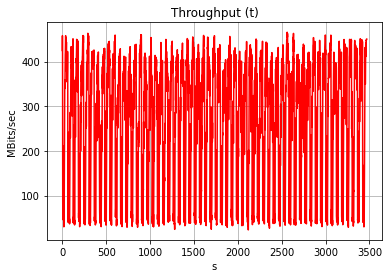

In [2]:
# DOWNLINK TCP  
RTT_values = ping_parser("ping.1s")
bitrate_values = iperf3_parser("iperf3.downlink.json")
#  jitter_values, packet_loss_values = iperf3_parser("iperf3.downlink.udp.json")
jitter_values = None
packet_loss_values = None

# Round and scaling
RTT_values = np.array(RTT_values)
bitrate_values = np.array(bitrate_values[::1]) / 10**6


fig, ax = plt.subplots(1, 1)

## RTT
# print("\nRTT statistics: ")
# mean, std, confidence_interval = get_stats(RTT_values)

# t = np.arange(0, len(RTT_values))
# ax[0].plot(t, RTT_values)
# ax[0].set(xlabel='s', ylabel='ms',
#        title='RTT (t)')
# ax[0].grid()

# ax[0, 1].plot(t, RTT_values)
# ax[0, 1].set(xlabel='s', ylabel='ms',
#        title='RTT (CDF)')
# ax[0, 1].grid()

t = np.arange(0, len(bitrate_values))
## Throughput
print("\nThroughput stats: ")
mean, std, confidence_interval = get_stats(bitrate_values)

ax.plot(t, bitrate_values, 'r')
ax.set(xlabel='s', ylabel='MBits/sec',
       title='Throughput (t)')
ax.grid()

# ax[1, 1].plot(t, bitrate_values, 'r')
# ax[1, 1].set(xlabel='s', ylabel='MBits/sec',
#        title='Throughput (CDF)')
# ax[1, 1].grid()

## Jitter
if jitter_values:
       jitter_values = np.round(np.array(jitter_values), 3)
       print("\nJitter stats: ")
       mean, std, confidence_interval = get_stats(jitter_values)

       ax[2].plot(t, jitter_values,'g')
       ax[2].set(xlabel='s', ylabel='ms',
              title='Jitter (t)')
       ax[2].grid()

       # ax[2, 1].plot(t, jitter_values,'g')
       # ax[2, 1].set(xlabel='s', ylabel='ms',
       #        title='Jitter (CDF)')
       # ax[2, 1].grid()

## Packet loss
if packet_loss_values:
       packet_loss_values = np.array(packet_loss_values)
       print("\nPacket loss stats: ")
       mean, std, confidence_interval = get_stats(packet_loss_values)

       ax[3].plot(t, packet_loss_values,'m')
       ax[3].set(xlabel='s', ylabel='%',
              title='Packet loss (t)')
       ax[3].grid()

       # ax[3, 1].plot(t, packet_loss_values,'m')
       # ax[3, 1].set(xlabel='s', ylabel='%',
       #        title='Packet loss (CDF)')
       # ax[3, 1].grid()

fig.savefig("downlink.png")
plt.show()






